Missing data points in each column:
 Age            0
SystolicBP     0
DiastolicBP    0
BS             0
BodyTemp       0
HeartRate      0
RiskLevel      0
dtype: int64
Dataset shape after dropping missing values: (1014, 7)
Unique values in 'RiskLevel' before mapping: ['high risk' 'low risk' 'mid risk']
Unique values in 'RiskLevel' after mapping: ['H' 'L' 'M']
No missing values in 'RiskLevel' after mapping


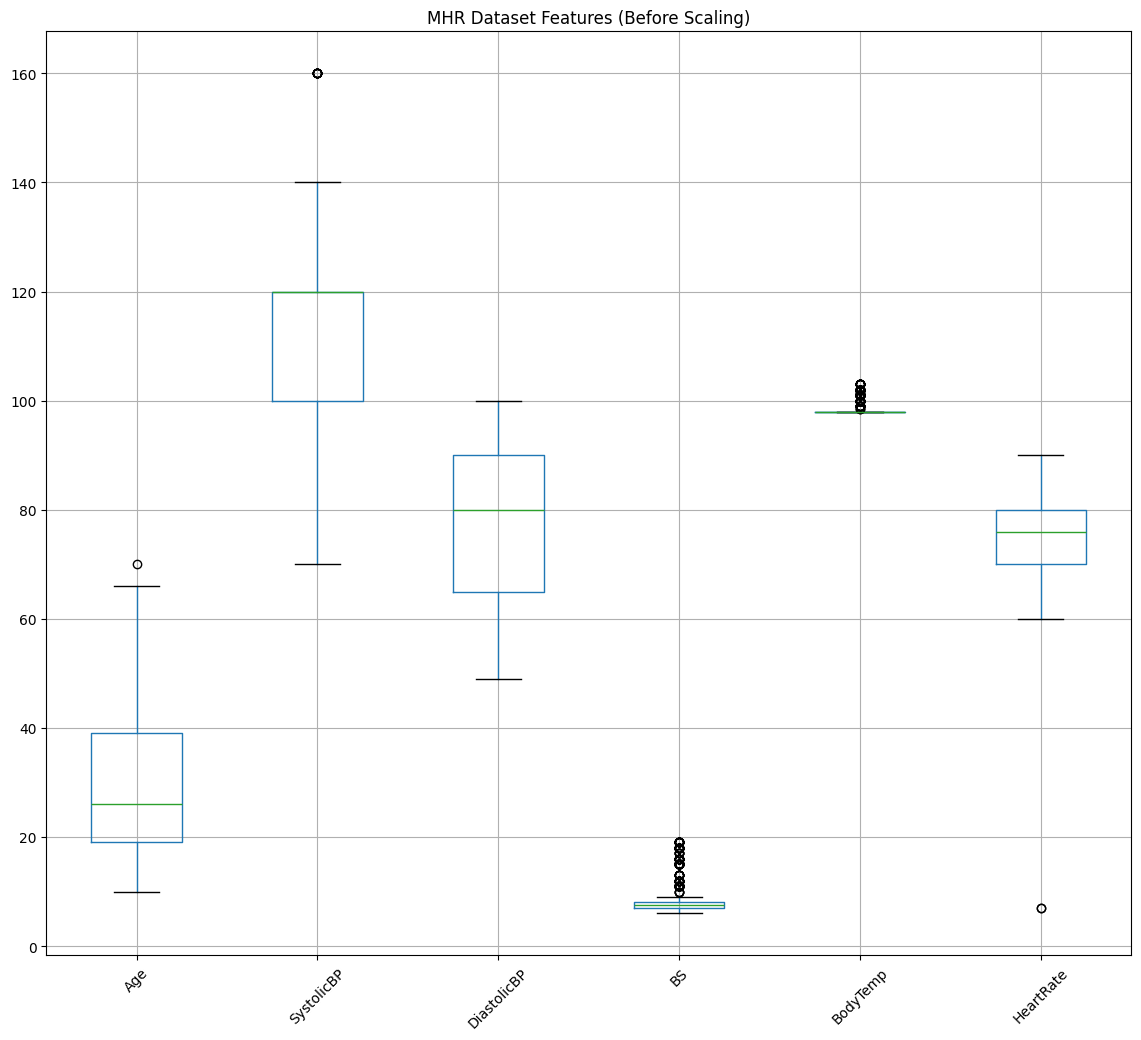

C:\Users\Bahrami\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Bahrami\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Bahrami\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Bahrami\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before o

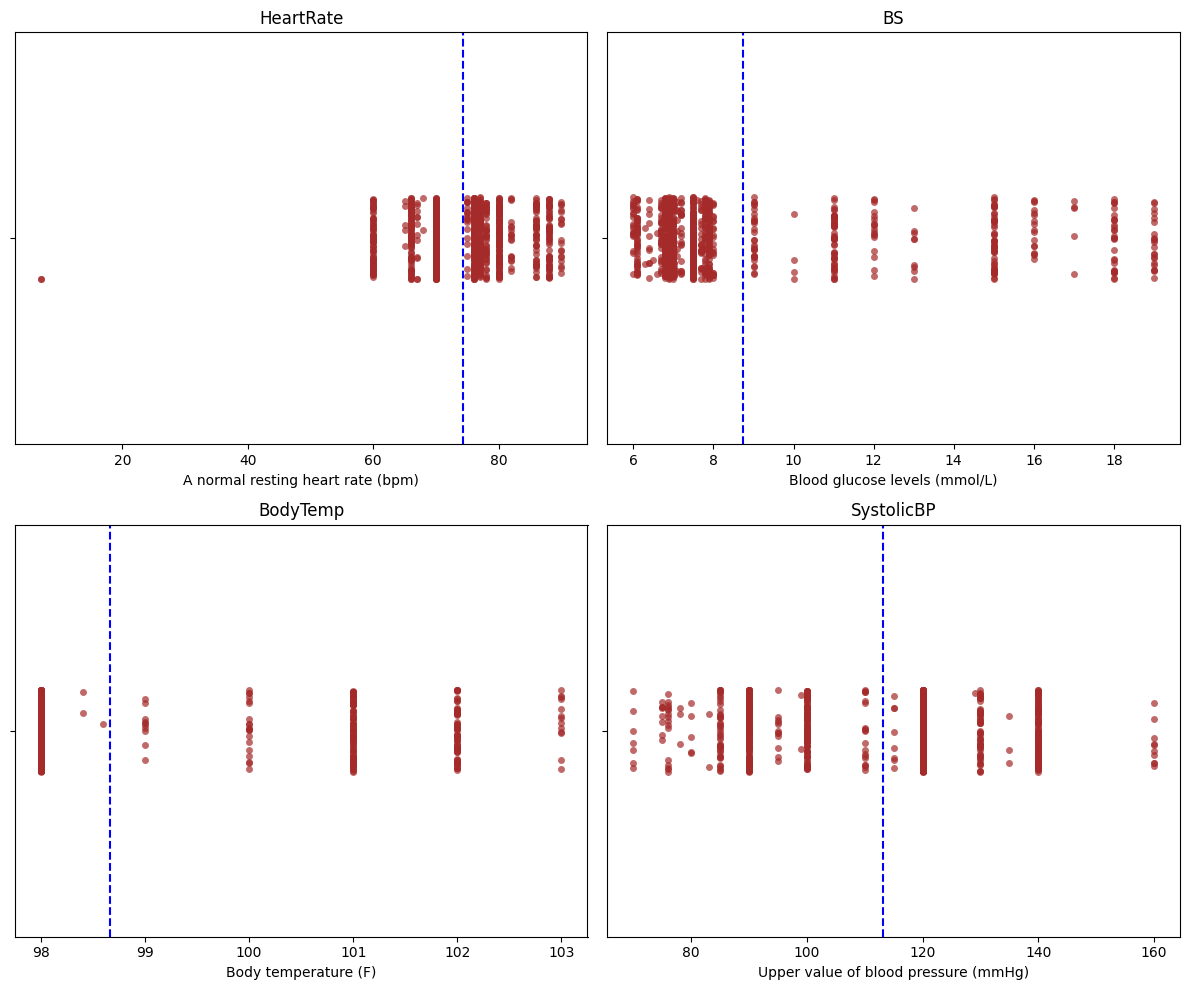

Lower Threshold Value: 50.035668331583, Upper Threshold Value: 98.56788196427499
Outliers: [7 7]
     Age  SystolicBP  DiastolicBP   BS  BodyTemp  HeartRate RiskLevel
499   16         120           75  7.9      98.0          7         L
908   16         120           75  7.9      98.0          7         L
     Age  SystolicBP  DiastolicBP   BS  BodyTemp  HeartRate RiskLevel
499   16         120           75  7.9      98.0         60         L
908   16         120           75  7.9      98.0         60         L


In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats.mstats import winsorize
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scipy.special import expit  # Import expit for softmax scaling
from scipy.stats import norm
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score
from sklearn.metrics import roc_curve, roc_auc_score, auc
from itertools import cycle
from sklearn.preprocessing import label_binarize

# Read the dataset from a CSV file and load it to a DataFrame
dataset = pd.read_csv('MHR.csv')

# Convert infinite values to NaN
dataset.replace([np.inf, -np.inf], np.nan, inplace=True)

# Checking for missing data points
missing_data = dataset.isnull().sum()
print("Missing data points in each column:\n", missing_data)

# Casewise deletion if necessary (removing rows with any missing values)
dataset = dataset.dropna()
print("Dataset shape after dropping missing values:", dataset.shape)

# Inspect unique values in the RiskLevel column before mapping
unique_risk_levels = dataset['RiskLevel'].unique()
print("Unique values in 'RiskLevel' before mapping:", unique_risk_levels)

# Correct the risk mapping based on the actual unique values
risk_mapping = {'low risk': 'L', 'mid risk': 'M', 'high risk': 'H',
                'Low risk': 'L', 'Mid risk': 'M', 'High risk': 'H'}

# Map the risk levels to single characters
dataset['RiskLevel'] = dataset['RiskLevel'].map(risk_mapping)

# Verify the mapping
print("Unique values in 'RiskLevel' after mapping:", dataset['RiskLevel'].unique())

# Ensure no missing values in 'RiskLevel' after mapping
missing_risk_levels = dataset['RiskLevel'].isnull().sum()
if missing_risk_levels > 0:
    print(f"Warning: There are {missing_risk_levels} missing values in 'RiskLevel' after mapping.")
    print(dataset[dataset['RiskLevel'].isnull()]['RiskLevel'])
else:
    print("No missing values in 'RiskLevel' after mapping")

# Checking and exploring the dataset for outliers and other characteristics by boxplot
plt.figure(figsize=(14, 12))
dataset.drop(columns='RiskLevel').boxplot()
plt.title('MHR Dataset Features (Before Scaling)')
plt.xticks(rotation=45)
plt.show()

# Further check of outliers by Cleveland dotplot
# List of features to plot with corresponding x-axis labels
features = {
    'HeartRate': 'A normal resting heart rate (bpm)',
    'BS': 'Blood glucose levels (mmol/L)',
    'BodyTemp': 'Body temperature (F)',
    'SystolicBP': 'Upper value of blood pressure (mmHg)'
}

# Set up the figure and subplots
plt.figure(figsize=(12, 10))
for i, (feature, xlabel) in enumerate(features.items(), 1):
    plt.subplot(2, 2, i)
    sns.stripplot(x=dataset[feature], color='brown', alpha=0.7, orient='h')
    plt.axvline(dataset[feature].mean(), color='blue', linestyle='--')
    plt.xlabel(xlabel)
    plt.title(feature)
plt.savefig('MHR_Dataset_Features_Before_Scaling.png', format='png')
plt.tight_layout()
plt.show()

# Check outlier through z-score (standard deviation: -3, +3)
heartRate = dataset['HeartRate']
lower_threshold = heartRate.mean() - 3 * heartRate.std()
upper_threshold = heartRate.mean() + 3 * heartRate.std()
outliers = heartRate[(heartRate < lower_threshold) | (heartRate > upper_threshold)]
print(f"Lower Threshold Value: {lower_threshold}, Upper Threshold Value: {upper_threshold}")
print(f"Outliers: {outliers.values}")

# Display rows that have HeartRate values as outliers
outlier_rows = dataset[dataset['HeartRate'].isin(outliers)]
print(outlier_rows)

# Fixing the outliers by Winsorizing
dataset['HeartRate'] = winsorize(dataset['HeartRate'], limits=[0.05, 0.05])
print(dataset.iloc[[499,908]])

# Save the cleaned dataset to a CSV file
dataset.to_csv('cleaned_MHR.csv', index=False)


Percentage of Women in Dataset in Each Class: L -> 40.04%
Percentage of Women in Dataset in Each Class: M -> 33.14%
Percentage of Women in Dataset in Each Class: H -> 26.82%


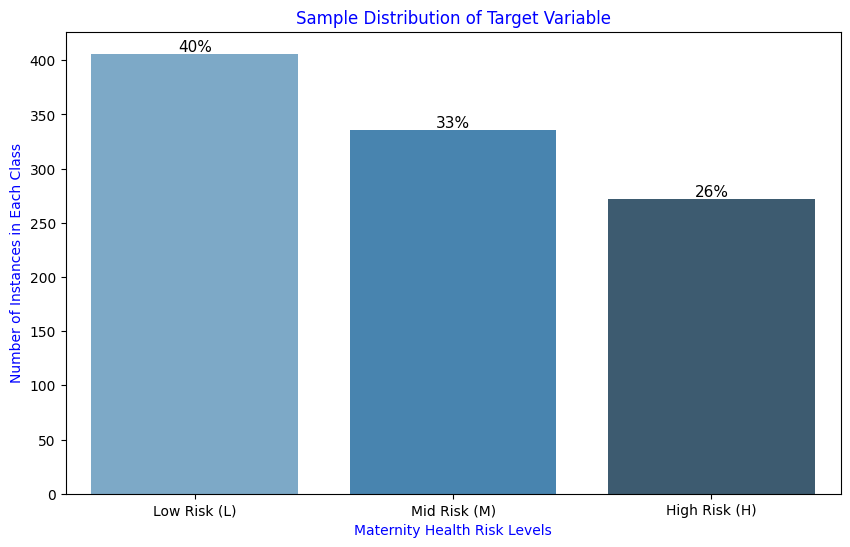

In [3]:
dataset = pd.read_csv('cleaned_MHR.csv')

# Function to calculate and print the percentage of each class
def sort_class(cls, data):
    for c in cls:
        percentage = round((data[data['RiskLevel'] == c].shape[0] / data.shape[0]) * 100, 2)
        print(f"Percentage of Women in Dataset in Each Class: {c} -> {percentage}%")

# Vector of class/level in target variables
vec = ['L', 'M', 'H']  # Adjust according to the actual class labels in your dataset
sort_class(vec, dataset)  # Call the function to execute

# Count the total of each class in the dataset
high_risk_class = dataset[dataset['RiskLevel'] == 'H'].shape[0]
mid_risk_class = dataset[dataset['RiskLevel'] == 'M'].shape[0]
low_risk_class = dataset[dataset['RiskLevel'] == 'L'].shape[0]

# Total the classes in the dataset
total = high_risk_class + mid_risk_class + low_risk_class

# Put the classes into a vector
CLASSES_TOTAL = [low_risk_class, mid_risk_class, high_risk_class]

# Put each risk level into vector
Risk_Level = ['Low Risk (L)', 'Mid Risk (M)', 'High Risk (H)']

# Calculate the percentage of each class
pLow = round(low_risk_class / total * 100, 0)
pMid = round(mid_risk_class / total * 100, 0)
pHigh = round(high_risk_class / total * 100, 0)

# Put percentage of classes into vector
percentage = [pLow, pMid, pHigh]

# Put the risk level, classes, and percentage vectors into a DataFrame
MHR_Class = pd.DataFrame({
    'Risk_Level': Risk_Level,
    'CLASSES_TOTAL': CLASSES_TOTAL,
    'percentage': percentage
})

# Order the risk level by the specified order
order = ['Low Risk (L)', 'Mid Risk (M)', 'High Risk (H)']

# Draw the bar chart of the Target Variable Class percentages
plt.figure(figsize=(10, 6))
bar_plot = sns.barplot(x='Risk_Level', y='CLASSES_TOTAL', data=MHR_Class, palette='Blues_d', order=order)
# Add labels to the bars
for p in bar_plot.patches:
    bar_plot.annotate(f"{int(p.get_height() / total * 100)}%",
                      (p.get_x() + p.get_width() / 2., p.get_height()),
                      ha='center', va='center', fontsize=11, color='black', xytext=(0, 5),
                      textcoords='offset points')

# Add titles and labels
plt.title("Sample Distribution of Target Variable", color='blue')
plt.xlabel("Maternity Health Risk Levels", color='blue')
plt.ylabel("Number of Instances in Each Class", color='blue')
plt.savefig('Sample Distribution of Target Variable', format='png')
plt.show()

Min-Max Scaling:
         Age  SystolicBP  DiastolicBP        BS  BodyTemp  HeartRate
0  0.250000    0.666667     0.607843  0.692308       0.0   0.928571
1  0.416667    0.777778     0.803922  0.538462       0.0   0.357143
2  0.316667    0.222222     0.411765  0.153846       0.4   0.714286
3  0.333333    0.777778     0.705882  0.076923       0.0   0.357143
4  0.416667    0.555556     0.215686  0.007692       0.0   0.571429
Z-Score Scaling (Standard):
         Age  SystolicBP  DiastolicBP        BS  BodyTemp  HeartRate
0 -0.361738    0.913396     0.255023  1.905890 -0.485215   1.558098
1  0.380777    1.457027     0.975539  1.298340 -0.485215  -0.585244
2 -0.064732   -1.261127    -0.465493 -0.220537  0.973884   0.754344
3  0.009519    1.457027     0.615281 -0.524312 -0.485215  -0.585244
4  0.380777    0.369765    -1.186009 -0.797710 -0.485215   0.218509
Z-Score Scaling (sd * 2):
         Age  SystolicBP  DiastolicBP        BS  BodyTemp  HeartRate
0 -0.180780    0.456473     0.127449  0.95

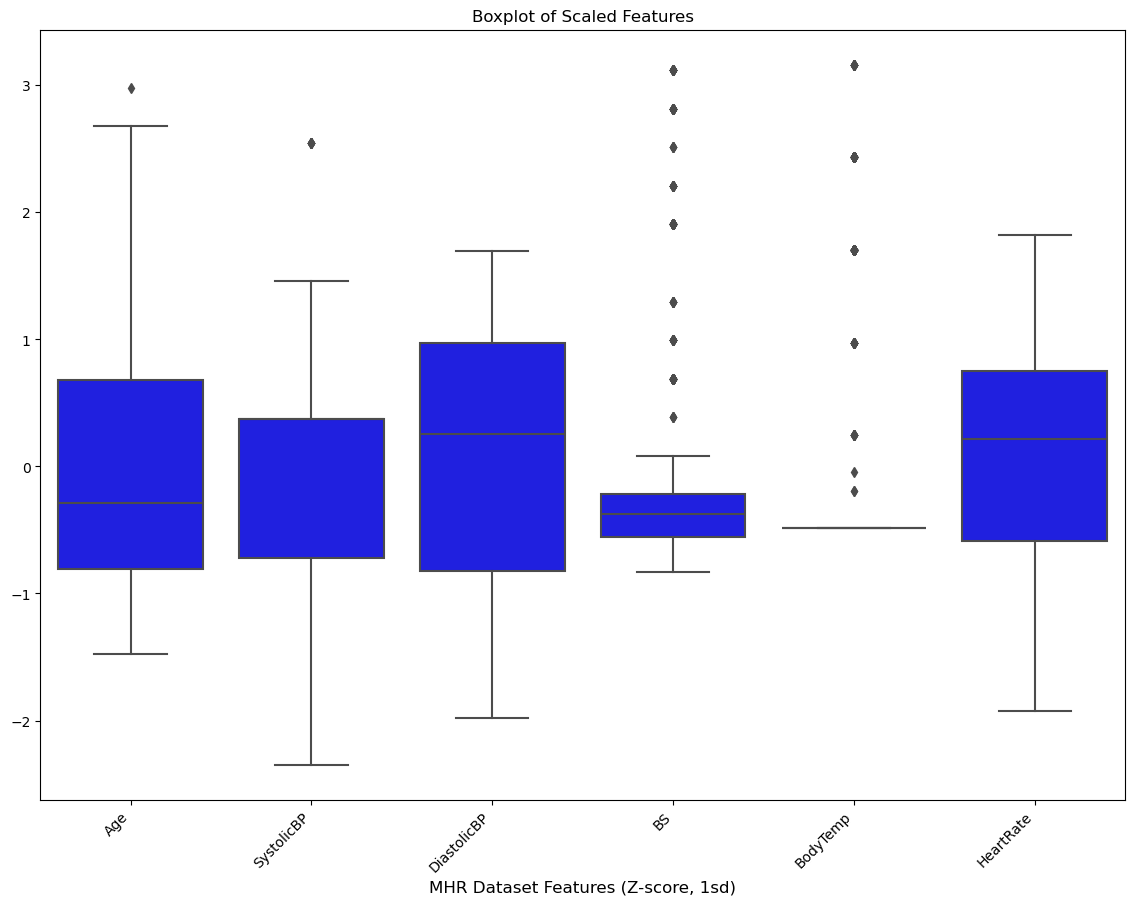

C:\Users\Bahrami\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Bahrami\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Bahrami\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Bahrami\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before o

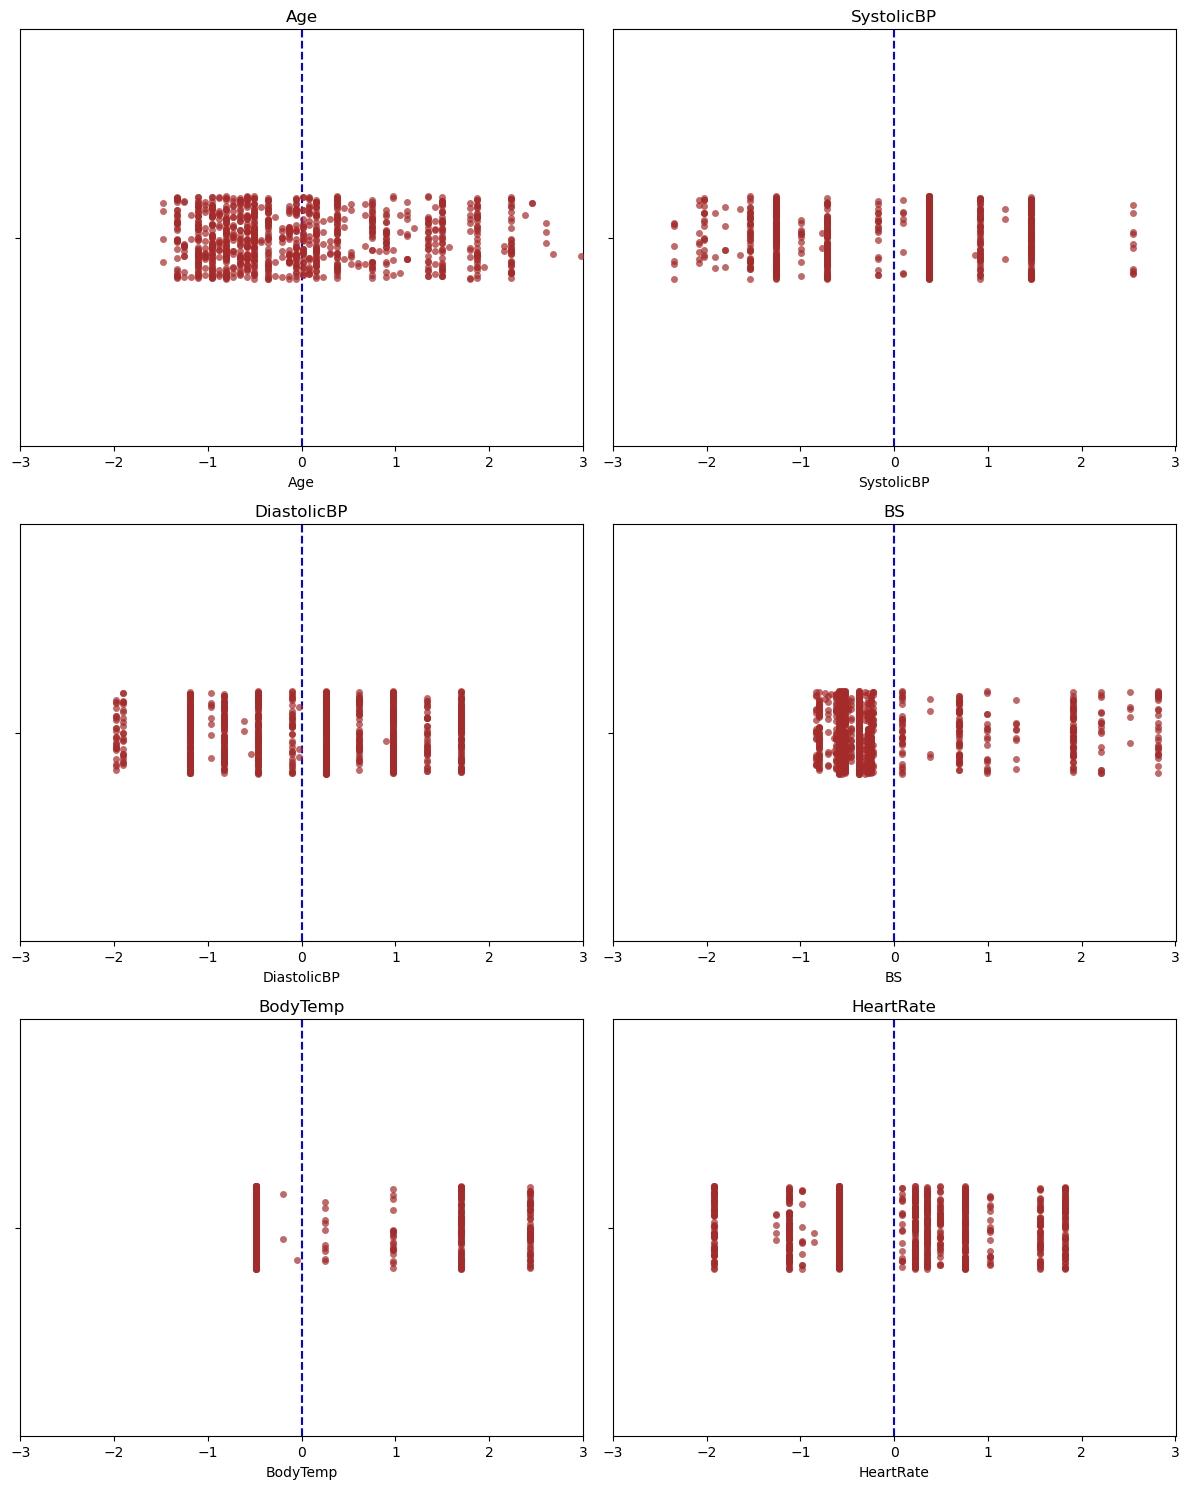

C:\Users\Bahrami\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Bahrami\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Bahrami\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Bahrami\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before o

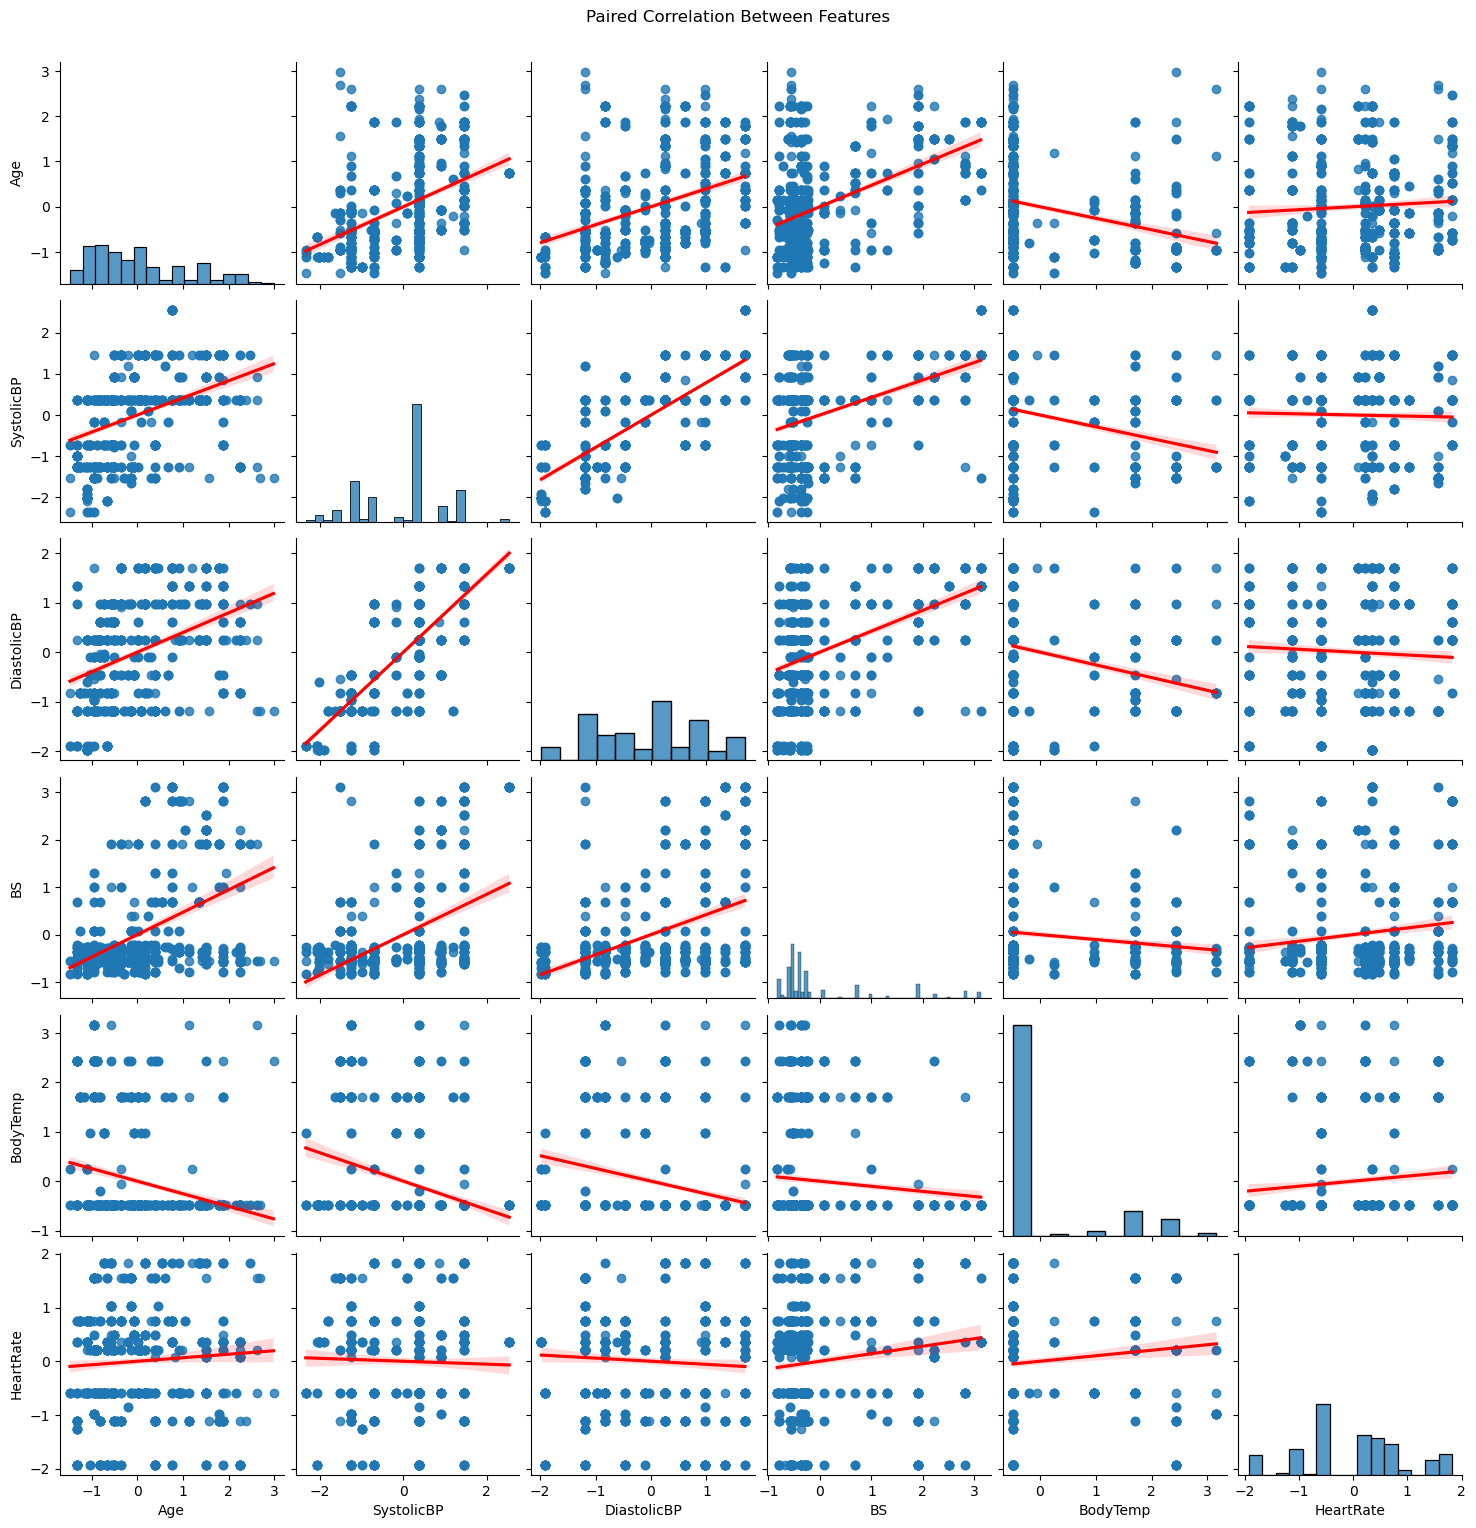

In [3]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scipy.special import expit  # Import expit for softmax scaling
# Read the cleaned dataset from the CSV file
dataset = pd.read_csv('cleaned_MHR.csv')

# Exclude the target variable
features = dataset.iloc[:, :-1]

# Scaling by min-max method
scaler_minmax = MinMaxScaler()
scale_minmax = pd.DataFrame(scaler_minmax.fit_transform(features), columns=features.columns)

# Scaling by z-score (standard scaling)
scaler_zscore = StandardScaler()
scale_zscore1 = pd.DataFrame(scaler_zscore.fit_transform(features), columns=features.columns)
# Scaling by z-score with different standard deviation (sd multiplied by 2)
scale_zscore2 = pd.DataFrame(features.apply(lambda x: (x - x.mean()) / (2 * x.std())), columns=features.columns)

# Softmax scaling function
def softmax_scaling(x, lambda_val):
    return expit(lambda_val * (x - x.mean()) / x.std())

# Scaling by soft-max with various lambda values
lambda_values = [1, 2, 3, 4, 5, 10, 15, 21, 30]
softmax_scaled_dfs = {}

for lambda_val in lambda_values:
    softmax_scaled_dfs[f'scale_softmax{lambda_val}'] = pd.DataFrame(features.apply(lambda x: softmax_scaling(x, lambda_val)), columns=features.columns)

# Combine all scaled data into a single DataFrame (if needed)
# Here is an example for one of the softmax scaled DataFrames, you can add others similarly
scaled_data = pd.concat([scale_minmax, scale_zscore1, scale_zscore2, softmax_scaled_dfs['scale_softmax1']], axis=1, keys=['minmax', 'zscore1', 'zscore2', 'softmax1'])

# For demonstration purposes, let's print the first few rows of each scaled DataFrame
print("Min-Max Scaling:\n", scale_minmax.head())
print("Z-Score Scaling (Standard):\n", scale_zscore1.head())
print("Z-Score Scaling (sd * 2):\n", scale_zscore2.head())
print("Softmax Scaling (λ=1):\n", softmax_scaled_dfs['scale_softmax1'].head())

features = dataset.iloc[:, :-1]

# Scaling by z-score (standard scaling)
scaler_zscore = StandardScaler()
scaled_data = pd.DataFrame(scaler_zscore.fit_transform(features), columns=features.columns)

# Box plot to explore data after normalization
plt.figure(figsize=(14, 10))
sns.boxplot(data=scaled_data, color='blue')
plt.xlabel('MHR Dataset Features (Z-score, 1sd)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.title('Boxplot of Scaled Features')
plt.show()

# Cleveland dot plot to further check for outliers
plt.figure(figsize=(12, 15))

for i, column in enumerate(scaled_data.columns, 1):
    plt.subplot(3, 2, i)
    sns.stripplot(x=scaled_data[column], color='brown', alpha=0.7)
    plt.axvline(scaled_data[column].mean(), color='blue', linestyle='--')
    plt.xlabel(column)
    plt.xlim(-3 * scaled_data[column].std(), 3 * scaled_data[column].std())
    plt.title(f'{column}')

plt.tight_layout()
plt.show()

# Paired correlation between features
sns.pairplot(scaled_data, kind='reg', plot_kws={'line_kws':{'color':'red'}})
plt.suptitle('Paired Correlation Between Features', y=1.02)
plt.show()


C:\Users\Bahrami\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Bahrami\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Bahrami\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Bahrami\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before o

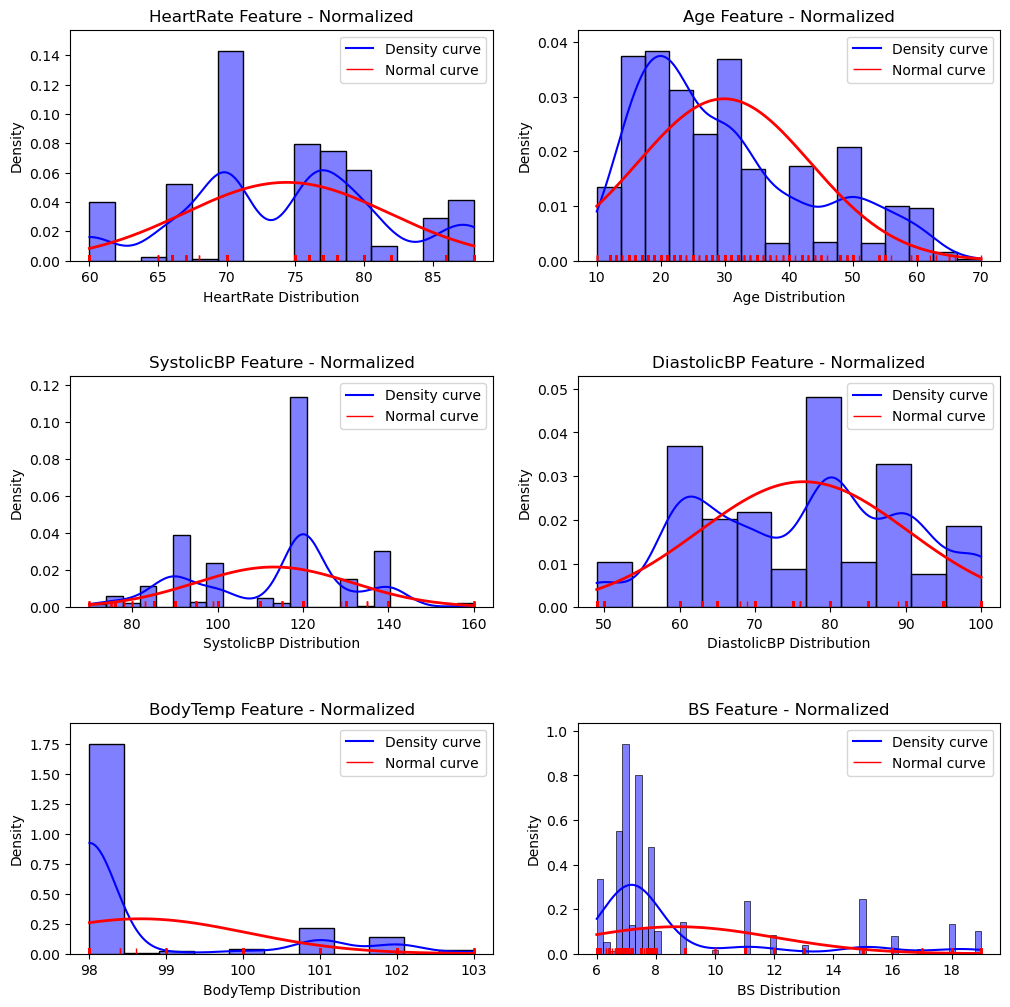

In [5]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
# Read the cleaned dataset from the CSV file
dataset = pd.read_csv('cleaned_MHR.csv')

# Define features
features = ['HeartRate', 'Age', 'SystolicBP', 'DiastolicBP', 'BodyTemp', 'BS']

# Set the layout: rows, column, and margins
plt.figure(figsize=(12, 12))
plt.subplots_adjust(hspace=0.5)

# Draw histogram for each feature in the dataset
for i, feature in enumerate(features, 1):
    plt.subplot(3, 2, i)
    sns.histplot(dataset[feature], kde=True, color="blue", stat="density")
    plt.title(f"{feature} Feature - Normalized")
    plt.xlabel(f"{feature} Distribution")
    plt.ylabel("Density")

    # Add rug plot
    sns.rugplot(dataset[feature], color="red")

    # Add density curve
    x = np.linspace(dataset[feature].min(), dataset[feature].max(), 1000)
    y = norm.pdf(x, dataset[feature].mean(), dataset[feature].std())
    plt.plot(x, y, color="red", linewidth=2, label="Normal curve")

    # Add legend
    plt.legend(["Density curve", "Normal curve"], loc="upper right")

plt.show()


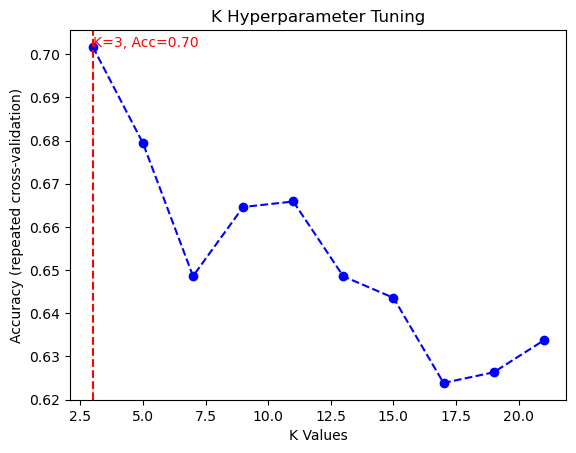

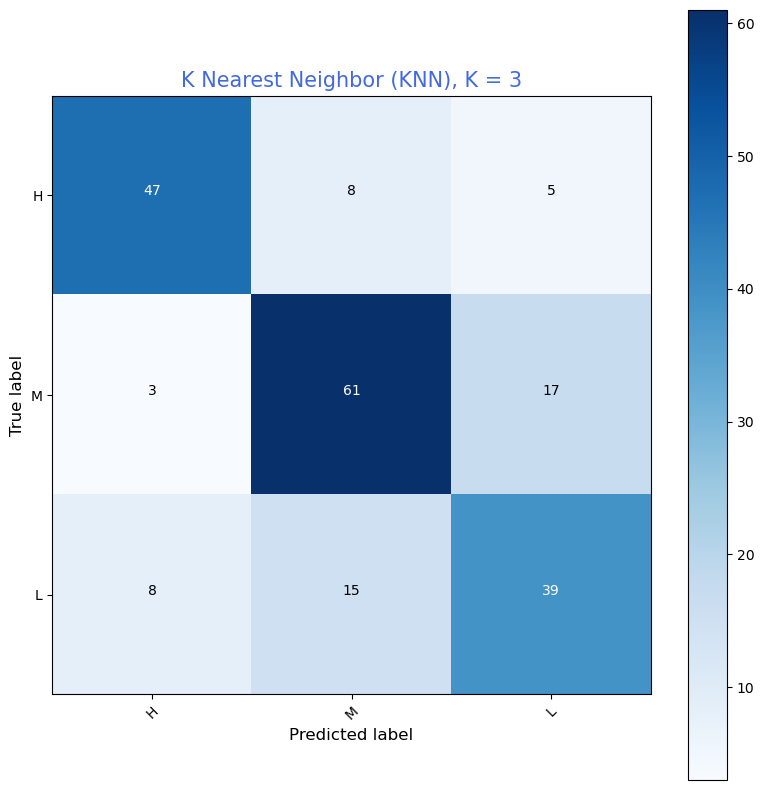

Accuracy: 0.72
Kappa: 0.58


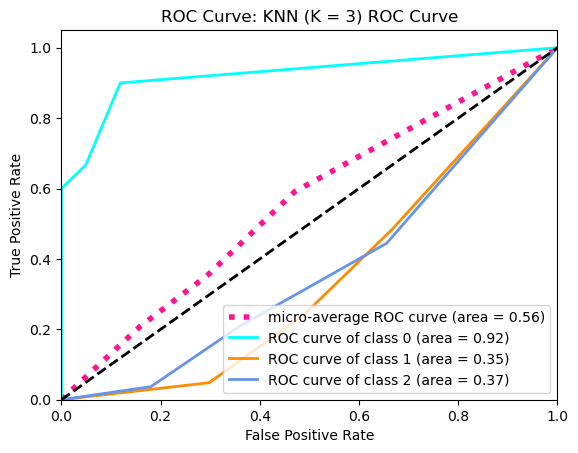

In [6]:

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score
from sklearn.metrics import roc_curve, roc_auc_score, auc
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.preprocessing import label_binarize

# Load the dataset
dataset = pd.read_csv('cleaned_MHR.csv')
# Splitting the dataset
np.random.seed(123)
X = dataset.drop('RiskLevel', axis=1)
y = dataset['RiskLevel']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)


# Function to visualize the confusion matrix
def visualize_cm(cm, mtype):
    classes = cm.columns  # Automatically get class names from the confusion matrix
    plt.figure(figsize=(8, 8))
    plt.title(mtype, fontsize=15, color='royalblue')

    # Create a heatmap for the confusion matrix
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    # Threshold for different text colors
    thresh = cm.values.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, f'{cm.iloc[i, j]}', horizontalalignment="center",
                 color="white" if cm.iloc[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label', fontsize=12)
    plt.xlabel('Predicted label', fontsize=12)
    plt.show()

    # Additional Metrics
    accuracy = np.trace(cm.values) / float(np.sum(cm.values))
    kappa = cohen_kappa_score(y_test, y_pred_best)
    print(f'Accuracy: {accuracy:.2f}')
    print(f'Kappa: {kappa:.2f}')


# Function to draw ROC curve for multiclass classification
def draw_roc(y_test, y_score, model_name):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    y_test_bin = label_binarize(y_test, classes=['H', 'M', 'L'])
    n_classes = y_test_bin.shape[1]

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    plt.figure()
    plt.plot(fpr["micro"], tpr["micro"], color='deeppink', linestyle=':', linewidth=4,
             label='micro-average ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]))

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} ROC Curve')
    plt.legend(loc="lower right")
    plt.show()


# Fitting K-NN to the Training set and Predicting the Test set results
k_values = [3, 5, 7, 9, 11, 13, 15, 17, 21]
predictions = {}

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    predictions[k] = knn.predict(X_test)

# Grid search for tuning the k hyper-parameter value
param_grid = {'n_neighbors': list(range(3, 22, 2))}
grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=10, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Best K value
best_k = grid_search.best_params_['n_neighbors']
best_accuracy = grid_search.best_score_

# Plot the data
k_values_grid = list(range(3, 22, 2))
accuracies = [grid_search.cv_results_['mean_test_score'][i] for i in range(len(param_grid['n_neighbors']))]

plt.plot(k_values_grid, accuracies, marker='o', linestyle='--', color='b')
plt.xlabel('K Values')
plt.ylabel('Accuracy (repeated cross-validation)')
plt.title('K Hyperparameter Tuning')
plt.axvline(x=best_k, color='r', linestyle='--')
plt.text(best_k, max(accuracies), f'K={best_k}, Acc={best_accuracy:.2f}', color='r')
plt.show()

# Create confusion matrix for the optimal KNN model
knn_best = KNeighborsClassifier(n_neighbors=best_k)
knn_best.fit(X_train, y_train)
y_pred_best = knn_best.predict(X_test)

cm_best = confusion_matrix(y_test, y_pred_best)
cm_best_df = pd.DataFrame(cm_best, index=['H', 'M', 'L'], columns=['H', 'M', 'L'])

# Visualize the confusion matrix
visualize_cm(cm_best_df, f'K Nearest Neighbor (KNN), K = {best_k}')

# Predict probabilities for ROC curve
y_score_best = knn_best.predict_proba(X_test)

# Draw the ROC curve
draw_roc(y_test, y_score_best, f'ROC Curve: KNN (K = {best_k})')


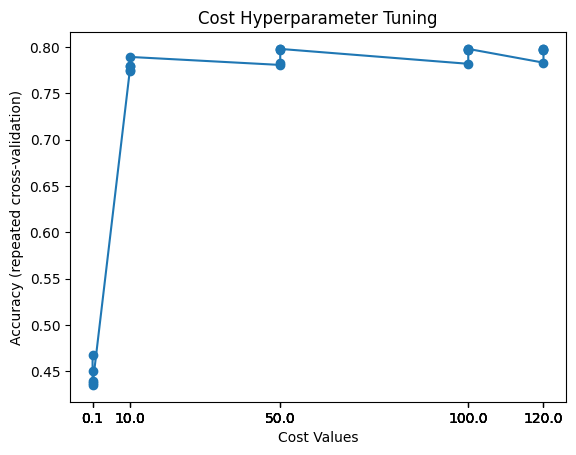

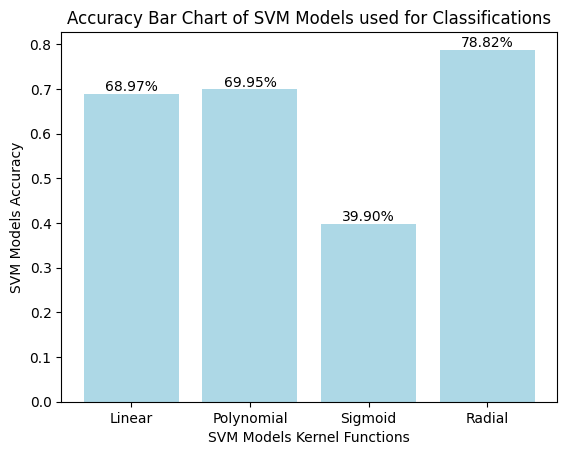

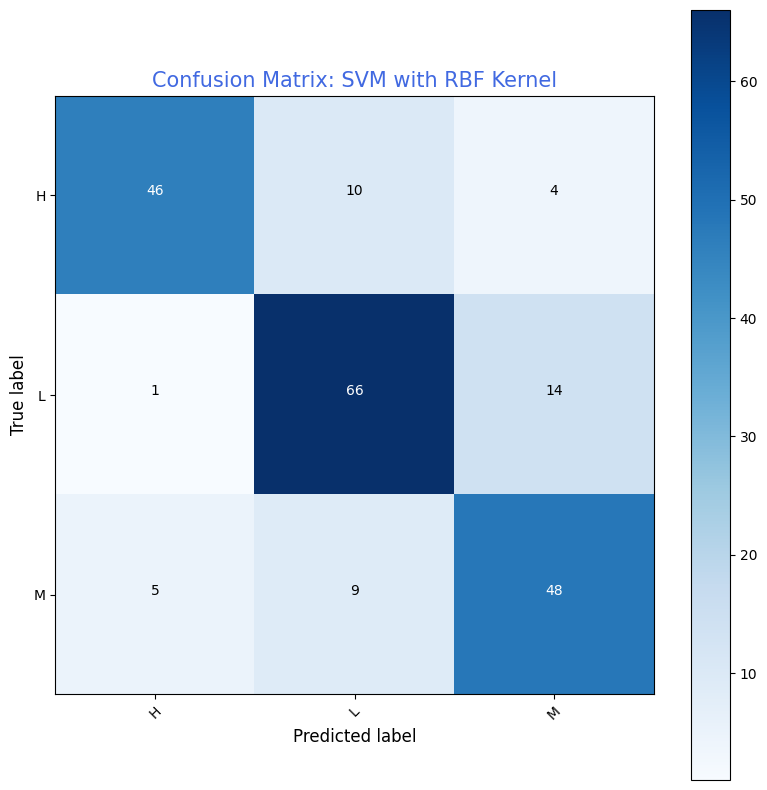

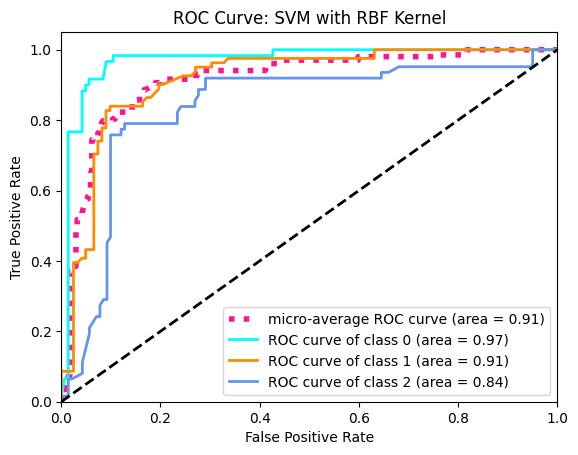

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, label_binarize
from itertools import cycle

# Load the dataset
dataset = pd.read_csv('cleaned_MHR.csv')

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(dataset['RiskLevel'])
# Split the dataset into training and testing sets
X = dataset.drop('RiskLevel', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# SVM with Linear kernel
svm_linear = SVC(kernel='linear', probability=True)
svm_linear.fit(X_train, y_train)
svm_linear_pred = svm_linear.predict(X_test)
svm_linear_cm = confusion_matrix(y_test, svm_linear_pred)

# SVM with Polynomial kernel
svm_polynomial = SVC(kernel='poly', degree=3, probability=True)
svm_polynomial.fit(X_train, y_train)
svm_polynomial_pred = svm_polynomial.predict(X_test)
svm_polynomial_cm = confusion_matrix(y_test, svm_polynomial_pred)

# SVM with Sigmoid kernel
svm_sigmoid = SVC(kernel='sigmoid', probability=True)
svm_sigmoid.fit(X_train, y_train)
svm_sigmoid_pred = svm_sigmoid.predict(X_test)
svm_sigmoid_cm = confusion_matrix(y_test, svm_sigmoid_pred)

# SVM with Radial Basis Function (RBF) kernel
svm_radial = SVC(kernel='rbf', probability=True, C=128, gamma=0.2224949)
svm_radial.fit(X_train, y_train)
svm_radial_pred = svm_radial.predict(X_test)
svm_radial_cm = confusion_matrix(y_test, svm_radial_pred)

# Grid search for tuning hyperparameters
param_grid = {'C': [0.1, 10, 50, 100, 120], 'gamma': [0.5, 1, 2, 3, 4]}
svm_grid = GridSearchCV(SVC(kernel='rbf', probability=True), param_grid, cv=10)
svm_grid.fit(X_train, y_train)
best_params = svm_grid.best_params_

# Plot accuracy levels
cost_values = [param['C'] for param in svm_grid.cv_results_['params']]
accuracy = svm_grid.cv_results_['mean_test_score']

plt.plot(cost_values, accuracy, marker='o', linestyle='-')
plt.xlabel('Cost Values')
plt.ylabel('Accuracy (repeated cross-validation)')
plt.title('Cost Hyperparameter Tuning')
plt.xticks(cost_values)
plt.show()

# Accuracy bar chart of SVM models
svm_models = ['Linear', 'Polynomial', 'Sigmoid', 'Radial']
accuracy_values = [np.mean(svm_linear_pred == y_test),
                   np.mean(svm_polynomial_pred == y_test),
                   np.mean(svm_sigmoid_pred == y_test),
                   np.mean(svm_radial_pred == y_test)]

plt.bar(svm_models, accuracy_values, color='lightblue')
plt.xlabel('SVM Models Kernel Functions')
plt.ylabel('SVM Models Accuracy')
for i in range(len(accuracy_values)):
    plt.text(i, accuracy_values[i], f'{accuracy_values[i]*100:.2f}%', ha='center', va='bottom')
plt.title('Accuracy Bar Chart of SVM Models used for Classifications')
plt.show()

# Function to visualize the confusion matrix
def visualize_cm(cm, title):
    classes = label_encoder.classes_
    plt.figure(figsize=(8, 8))
    plt.title(title, fontsize=15, color='royalblue')

    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, f'{cm[i, j]}', horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label', fontsize=12)
    plt.xlabel('Predicted label', fontsize=12)
    plt.show()

# Visualize confusion matrix for the SVM optimal model (RBF kernel)
visualize_cm(svm_radial_cm, 'Confusion Matrix: SVM with RBF Kernel')

# Draw ROC Curve for the SVM optimal model (RBF kernel)
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
n_classes = y_test_bin.shape[1]

y_score = svm_radial.predict_proba(X_test)
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
plt.plot(fpr["micro"], tpr["micro"], color='deeppink', linestyle=':', linewidth=4,
         label='micro-average ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]))

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: SVM with RBF Kernel')
plt.legend(loc="lower right")
plt.show()


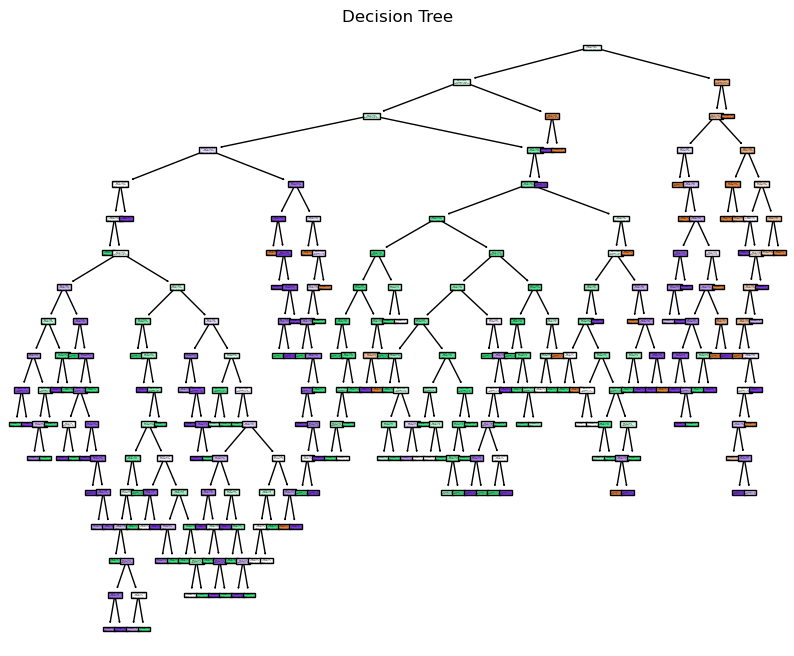

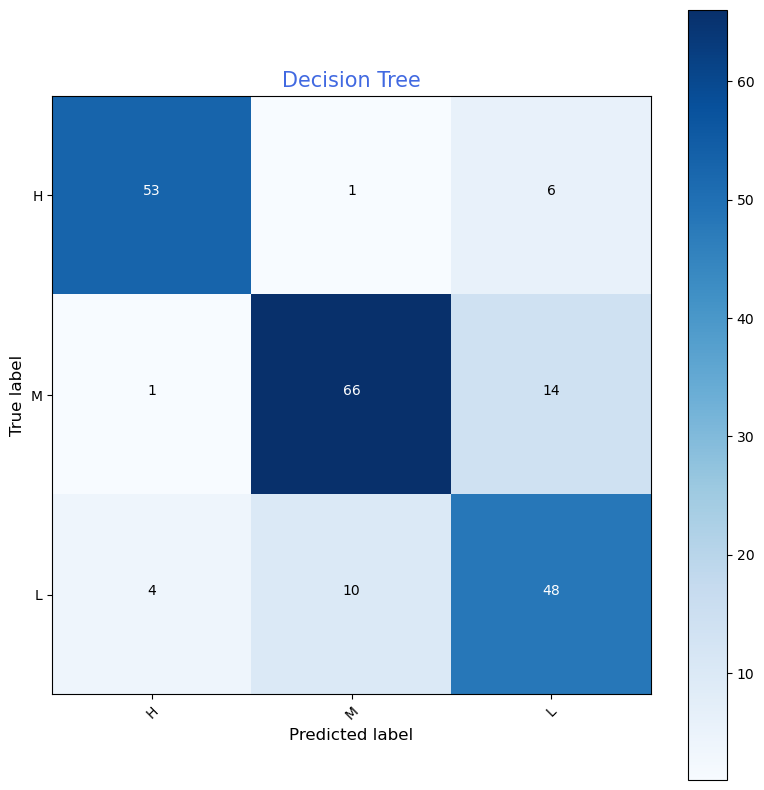

Accuracy: 0.82
Kappa: 0.73


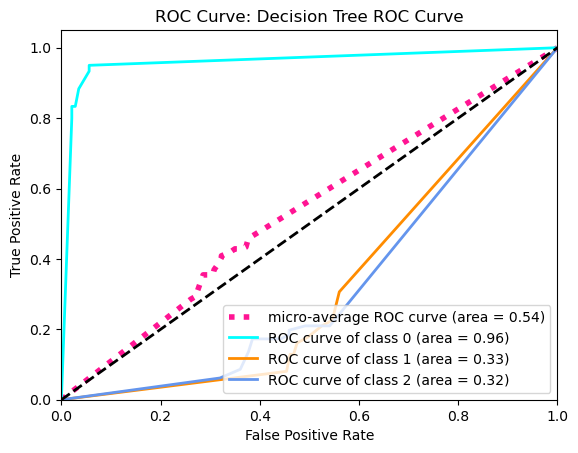

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import confusion_matrix, roc_curve, auc, cohen_kappa_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from itertools import cycle
# Load the dataset
dataset = pd.read_csv('cleaned_MHR.csv')

# Splitting the dataset
np.random.seed(123)
X = dataset.drop('RiskLevel', axis=1)
y = dataset['RiskLevel']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# Function to visualize the confusion matrix
def visualize_cm(cm, mtype):
    classes = cm.columns  # Automatically get class names from the confusion matrix
    plt.figure(figsize=(8, 8))
    plt.title(mtype, fontsize=15, color='royalblue')

    # Create a heatmap for the confusion matrix
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    # Threshold for different text colors
    thresh = cm.values.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, f'{cm.iloc[i, j]}', horizontalalignment="center",
                 color="white" if cm.iloc[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label', fontsize=12)
    plt.xlabel('Predicted label', fontsize=12)
    plt.show()

    # Additional Metrics
    accuracy = np.trace(cm.values) / float(np.sum(cm.values))
    kappa = cohen_kappa_score(y_test, pred_prun)
    print(f'Accuracy: {accuracy:.2f}')
    print(f'Kappa: {kappa:.2f}')

# Function to draw ROC curve for multiclass classification
def draw_roc(y_test, y_score, model_name):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    y_test_bin = label_binarize(y_test, classes=['H', 'M', 'L'])
    n_classes = y_test_bin.shape[1]

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    plt.figure()
    plt.plot(fpr["micro"], tpr["micro"], color='deeppink', linestyle=':', linewidth=4,
             label='micro-average ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]))

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

# Decision Tree Classifier
DTree_01 = DecisionTreeClassifier()
DTree_01.fit(X_train, y_train)

# Plot the tree
plt.figure(figsize=(10, 8))
plot_tree(DTree_01, filled=True, feature_names=X_train.columns)
plt.title("Decision Tree")
plt.show()

# Predictions for Decision Tree
pred_prun = DTree_01.predict(X_test)

# Confusion Matrix for Decision Tree
cm_prun = confusion_matrix(y_test, pred_prun)
cm_prun_df = pd.DataFrame(cm_prun, index=['H', 'M', 'L'], columns=['H', 'M', 'L'])

# Visualize the confusion matrix for Decision Tree
visualize_cm(cm_prun_df, "Decision Tree")

# Plot ROC Curve for Decision Tree
y_score_tree = DTree_01.predict_proba(X_test)
draw_roc(y_test, y_score_tree, "ROC Curve: Decision Tree")


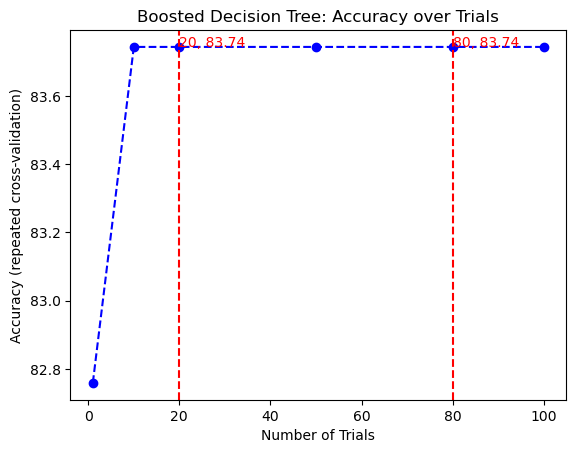

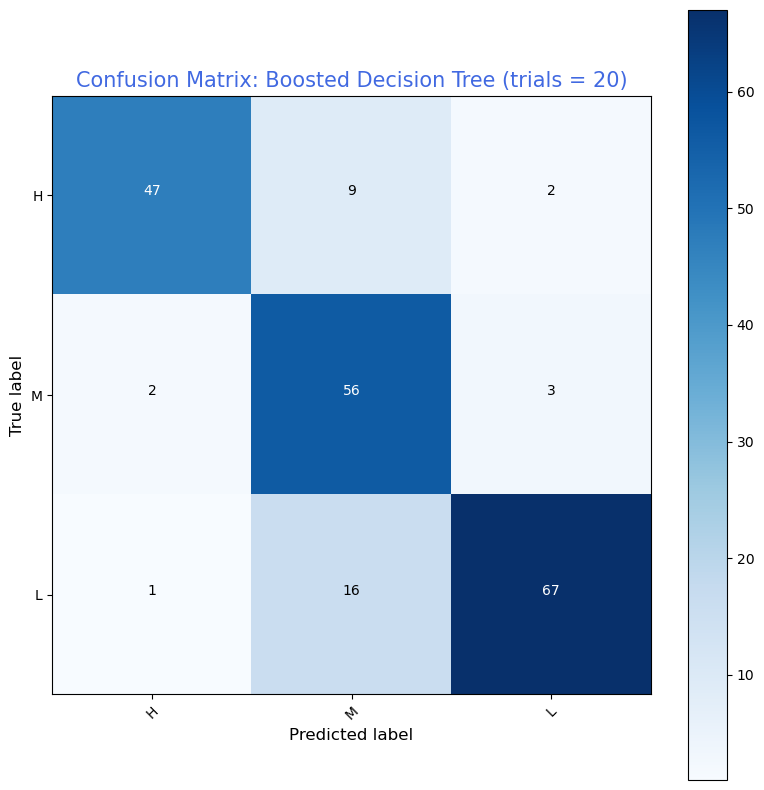

Accuracy: 0.84
Kappa: 0.75


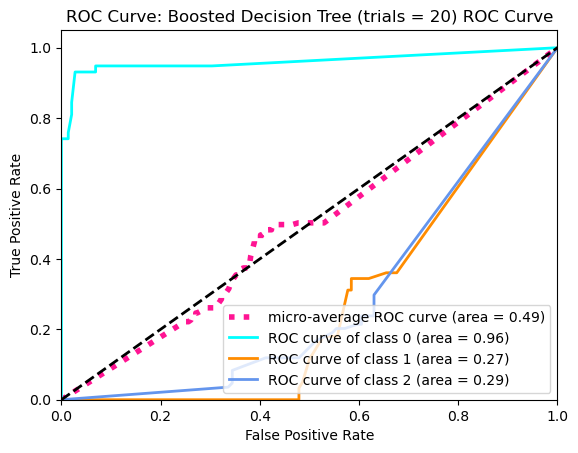

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, roc_curve, auc, cohen_kappa_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from itertools import cycle

# Load the dataset
dataset = pd.read_csv('cleaned_MHR.csv')

# Splitting the dataset
np.random.seed(12345)
X = dataset.drop('RiskLevel', axis=1)
y = dataset['RiskLevel']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12345)

# Function to visualize the confusion matrix
def visualize_cm(cm, mtype):
    classes = cm.columns
    plt.figure(figsize=(8, 8))
    plt.title(mtype, fontsize=15, color='royalblue')

    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.values.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, f'{cm.iloc[i, j]}', horizontalalignment="center",
                 color="white" if cm.iloc[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label', fontsize=12)
    plt.xlabel('Predicted label', fontsize=12)
    plt.show()

    accuracy = np.trace(cm.values) / float(np.sum(cm.values))
    kappa = cohen_kappa_score(y_test, pred_best)
    print(f'Accuracy: {accuracy:.2f}')
    print(f'Kappa: {kappa:.2f}')

# Function to draw ROC curve for multiclass classification
def draw_roc(y_test, y_score, model_name):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    y_test_bin = label_binarize(y_test, classes=['H', 'M', 'L'])
    n_classes = y_test_bin.shape[1]

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    plt.figure()
    plt.plot(fpr["micro"], tpr["micro"], color='deeppink', linestyle=':', linewidth=4,
             label='micro-average ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]))

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

# Boosting with AdaBoostClassifier
trial_values = [1, 10, 20, 50, 80, 100]
accuracies = []

for trials in trial_values:
    ada = AdaBoostClassifier(estimator=DecisionTreeClassifier(), n_estimators=trials, random_state=12345)
    ada.fit(X_train, y_train)
    pred = ada.predict(X_test)
    
    cm = confusion_matrix(y_test, pred, labels=['H', 'M', 'L'])
    cm_df = pd.DataFrame(cm, index=['H', 'M', 'L'], columns=['H', 'M', 'L'])
    accuracy = np.trace(cm) / np.sum(cm)
    accuracies.append(accuracy * 100)

# Plot the accuracy of models over the number of trials hyper-parameter values
plt.plot(trial_values, accuracies, marker='o', linestyle='--', color='b')
plt.xlabel('Number of Trials')
plt.ylabel('Accuracy (repeated cross-validation)')
plt.title('Boosted Decision Tree: Accuracy over Trials')
plt.axvline(x=20, color='r', linestyle='--')
plt.axvline(x=80, color='r', linestyle='--')
plt.text(20, max(accuracies), f'20, {max(accuracies):.2f}', color='r')
plt.text(80, max(accuracies), f'80, {max(accuracies):.2f}', color='r')
plt.show()

# Choosing the optimal model (trials = 20)
ada_best = AdaBoostClassifier(estimator=DecisionTreeClassifier(), n_estimators=20, random_state=12345)
ada_best.fit(X_train, y_train)
pred_best = ada_best.predict(X_test)

# Confusion Matrix for the optimal boosted model
cm_best = confusion_matrix(y_test, pred_best, labels=['H', 'M', 'L'])
cm_best_df = pd.DataFrame(cm_best, index=['H', 'M', 'L'], columns=['H', 'M', 'L'])
visualize_cm(cm_best_df, "Confusion Matrix: Boosted Decision Tree (trials = 20)")

# Plot ROC Curve for the optimal boosted model
y_score_best = ada_best.predict_proba(X_test)
draw_roc(y_test, y_score_best, "ROC Curve: Boosted Decision Tree (trials = 20)")


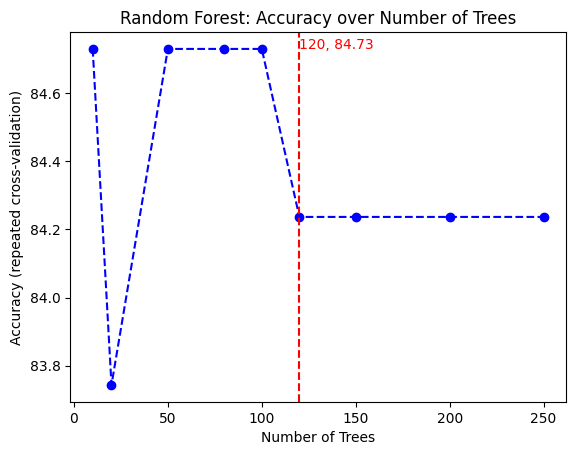

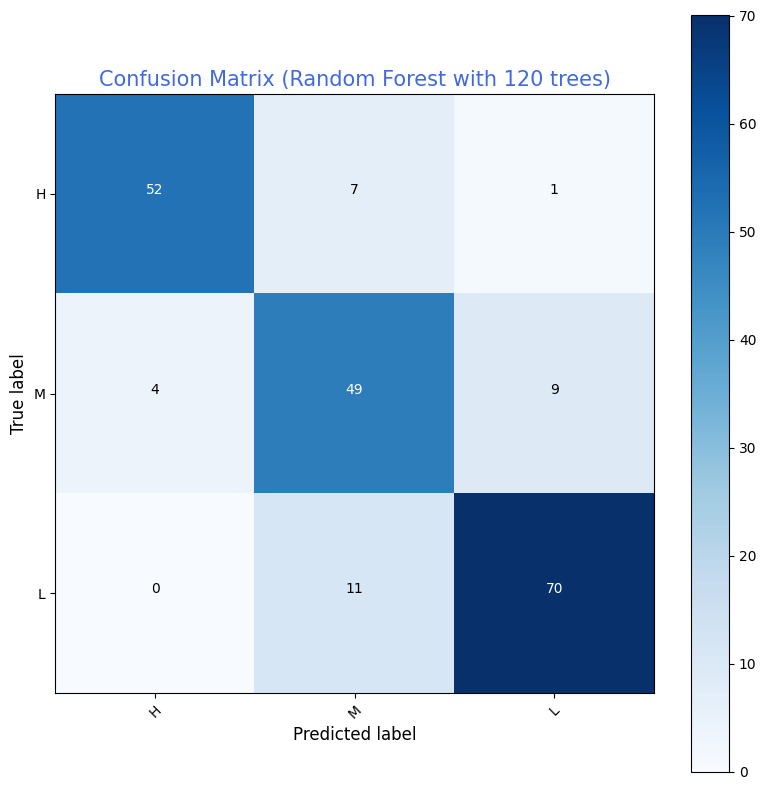

Accuracy: 0.84
Kappa: 0.76


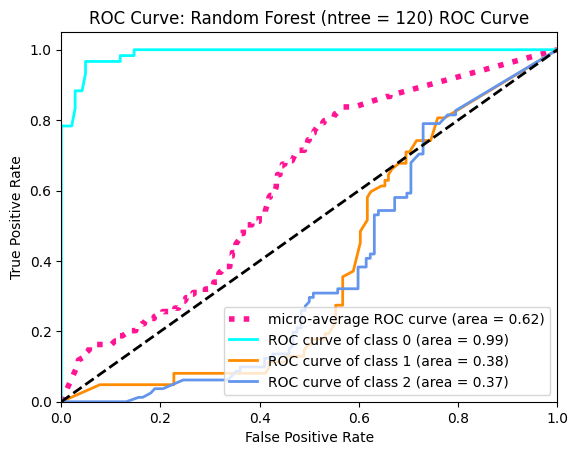

  N  Accuracy (%)  Error (%)    Kappa      AUC
 10     84.729064  15.270936 0.768623 0.569652
 20     83.743842  16.256158 0.754210 0.577407
 50     84.729064  15.270936 0.768282 0.583141
 80     84.729064  15.270936 0.768784 0.580398
100     84.729064  15.270936 0.768784 0.582119
120     84.236453  15.763547 0.761308 0.581613
150     84.236453  15.763547 0.761308 0.581627
200     84.236453  15.763547 0.761308 0.583741
250     84.236453  15.763547 0.761641 0.586451


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_curve, auc, cohen_kappa_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from itertools import cycle

# Load the dataset
dataset = pd.read_csv('cleaned_MHR.csv')

# Splitting the dataset
np.random.seed(123)
X = dataset.drop('RiskLevel', axis=1)
y = dataset['RiskLevel']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# Function to visualize the confusion matrix
def visualize_cm(cm, mtype):
    classes = cm.columns
    plt.figure(figsize=(8, 8))
    plt.title(mtype, fontsize=15, color='royalblue')

    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.values.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, f'{cm.iloc[i, j]}', horizontalalignment="center",
                 color="white" if cm.iloc[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label', fontsize=12)
    plt.xlabel('Predicted label', fontsize=12)
    plt.show()

    accuracy = np.trace(cm.values) / float(np.sum(cm.values))
    kappa = cohen_kappa_score(y_test, pred_best)
    print(f'Accuracy: {accuracy:.2f}')
    print(f'Kappa: {kappa:.2f}')

# Function to draw ROC curve for multiclass classification
def draw_roc(y_test, y_score, model_name):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    y_test_bin = label_binarize(y_test, classes=['H', 'M', 'L'])
    n_classes = y_test_bin.shape[1]

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    plt.figure()
    plt.plot(fpr["micro"], tpr["micro"], color='deeppink', linestyle=':', linewidth=4,
             label='micro-average ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]))

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

# Fitting Random Forest Classification to the Training set using different ntree hyper-parameter values
ntree_values = [10, 20, 50, 80, 100, 120, 150, 200, 250]
accuracies = []
errors = []
kappas = []
aucs = []

for ntree in ntree_values:
    rf = RandomForestClassifier(n_estimators=ntree, random_state=123)
    rf.fit(X_train, y_train)
    pred = rf.predict(X_test)
    
    cm = confusion_matrix(y_test, pred, labels=['H', 'M', 'L'])
    cm_df = pd.DataFrame(cm, index=['H', 'M', 'L'], columns=['H', 'M', 'L'])
    accuracy = np.trace(cm) / np.sum(cm)
    error = 1 - accuracy
    kappa = cohen_kappa_score(y_test, pred)
    
    y_score = rf.predict_proba(X_test)
    y_test_bin = label_binarize(y_test, classes=['H', 'M', 'L'])
    roc_auc = dict()
    for i in range(y_test_bin.shape[1]):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr, tpr)
    auc_mean = np.mean(list(roc_auc.values()))

    accuracies.append(accuracy * 100)
    errors.append(error * 100)
    kappas.append(kappa)
    aucs.append(auc_mean)

# Plot the accuracy of models over the number of ntree hyper-parameter values
plt.plot(ntree_values, accuracies, marker='o', linestyle='--', color='b')
plt.xlabel('Number of Trees')
plt.ylabel('Accuracy (repeated cross-validation)')
plt.title('Random Forest: Accuracy over Number of Trees')
optimal_ntree = 120
plt.axvline(x=optimal_ntree, color='r', linestyle='--')
plt.text(optimal_ntree, max(accuracies), f'{optimal_ntree}, {max(accuracies):.2f}', color='r')
plt.show()

# Choosing the optimal model (ntree = 120)
rf_best = RandomForestClassifier(n_estimators=optimal_ntree, random_state=123)
rf_best.fit(X_train, y_train)
pred_best = rf_best.predict(X_test)

# Confusion Matrix for the optimal model
cm_best = confusion_matrix(y_test, pred_best, labels=['H', 'M', 'L'])
cm_best_df = pd.DataFrame(cm_best, index=['H', 'M', 'L'], columns=['H', 'M', 'L'])
visualize_cm(cm_best_df, f"Confusion Matrix (Random Forest with {optimal_ntree} trees)")

# Plot ROC Curve for the optimal model
y_score_best = rf_best.predict_proba(X_test)
draw_roc(y_test, y_score_best, f"ROC Curve: Random Forest (ntree = {optimal_ntree})")

# Creating a DataFrame for the performance metrics
metrics_df = pd.DataFrame({
    'N': ntree_values,
    'Accuracy (%)': accuracies,
    'Error (%)': errors,
    'Kappa': kappas,
    'AUC': aucs
})

# Displaying the performance metrics in tabular format
print(metrics_df.to_string(index=False))


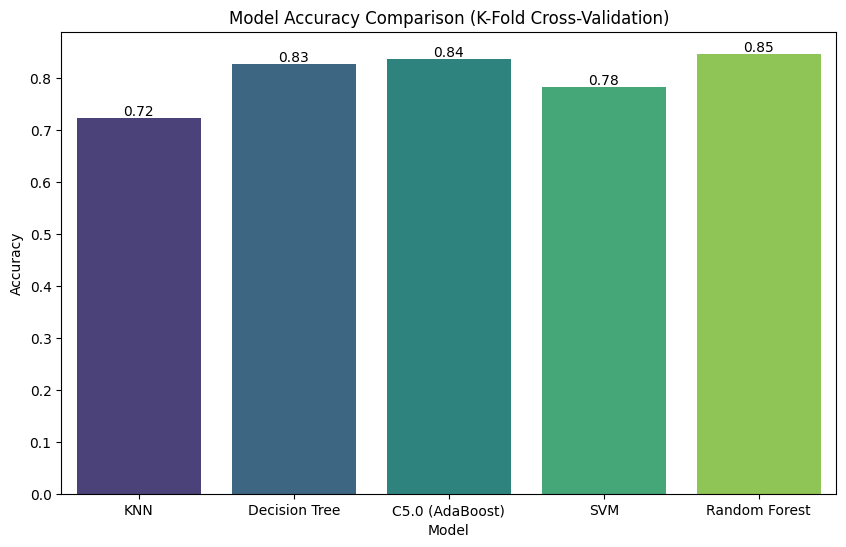

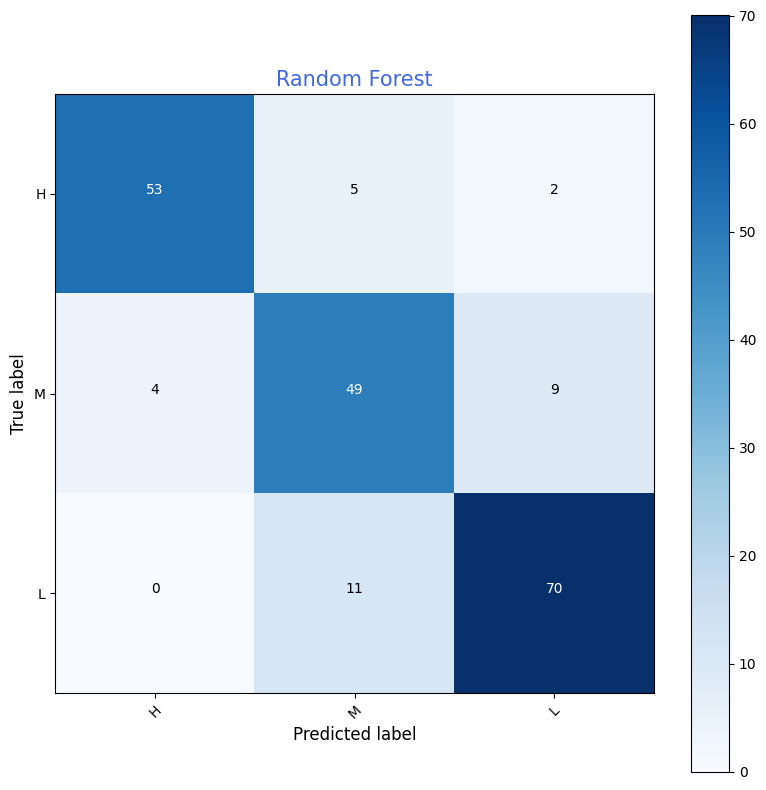

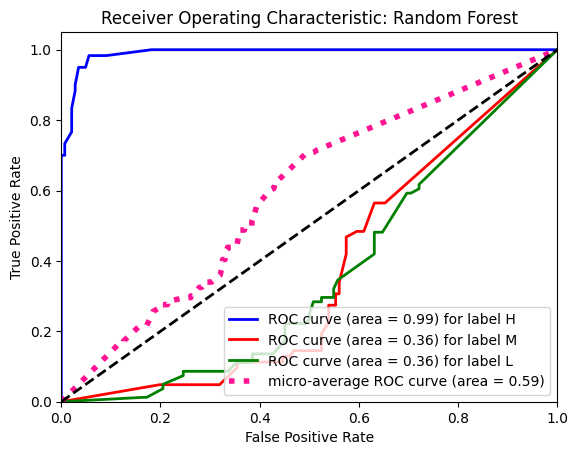

             Model  Accuracy  F1 Score  Precision    Recall  Cohen Kappa
0              KNN  0.724138  0.724161   0.724539  0.724138     0.581181
1    Decision Tree  0.827586  0.829074   0.831638  0.827586     0.739333
2  C5.0 (AdaBoost)  0.837438  0.838855   0.841098  0.837438     0.753867
3              SVM  0.783251  0.784234   0.788525  0.783251     0.670321
4    Random Forest  0.847291  0.848283   0.849891  0.847291     0.768623


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, cohen_kappa_score, roc_curve, auc, f1_score, precision_score, recall_score
from sklearn.preprocessing import label_binarize

# Load the dataset
dataset = pd.read_csv('cleaned_MHR.csv')

# Splitting the dataset
np.random.seed(123)
X = dataset.drop('RiskLevel', axis=1)
y = dataset['RiskLevel']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# Define the k-fold cross-validation
from sklearn.model_selection import StratifiedKFold
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=123)

# Binarize the output for ROC curve
y_train_bin = label_binarize(y_train, classes=['H', 'M', 'L'])
y_test_bin = label_binarize(y_test, classes=['H', 'M', 'L'])
n_classes = y_train_bin.shape[1]

# KNN
knn_params = {'n_neighbors': [3, 5, 7, 9, 11, 13, 15, 17, 19, 21]}
knn_grid = GridSearchCV(KNeighborsClassifier(), knn_params, cv=kf)
knn_grid.fit(X_train, y_train)
knn_pred = knn_grid.predict(X_test)
knn_cm = pd.DataFrame(confusion_matrix(y_test, knn_pred, labels=['H', 'M', 'L']), columns=['H', 'M', 'L'], index=['H', 'M', 'L'])
knn_accuracy = accuracy_score(y_test, knn_pred)
knn_f1 = f1_score(y_test, knn_pred, average='weighted')
knn_precision = precision_score(y_test, knn_pred, average='weighted')
knn_recall = recall_score(y_test, knn_pred, average='weighted')
knn_kappa = cohen_kappa_score(y_test, knn_pred)
knn_prob = knn_grid.predict_proba(X_test)

# Decision Tree
dt_params = {'max_depth': [None] + list(np.arange(1, 21))}
dt_grid = GridSearchCV(DecisionTreeClassifier(), dt_params, cv=kf)
dt_grid.fit(X_train, y_train)
dt_pred = dt_grid.predict(X_test)
dt_cm = pd.DataFrame(confusion_matrix(y_test, dt_pred, labels=['H', 'M', 'L']), columns=['H', 'M', 'L'], index=['H', 'M', 'L'])
dt_accuracy = accuracy_score(y_test, dt_pred)
dt_f1 = f1_score(y_test, dt_pred, average='weighted')
dt_precision = precision_score(y_test, dt_pred, average='weighted')
dt_recall = recall_score(y_test, dt_pred, average='weighted')
dt_kappa = cohen_kappa_score(y_test, dt_pred)
dt_prob = dt_grid.predict_proba(X_test)

# C5.0 equivalent (Decision Tree with boosting) using AdaBoost (fixed algorithm parameter)
c50_params = {'n_estimators': [10, 20, 50, 80, 100]}
c50_grid = GridSearchCV(AdaBoostClassifier(estimator=DecisionTreeClassifier(), algorithm='SAMME'), c50_params, cv=kf)
c50_grid.fit(X_train, y_train)
c50_pred = c50_grid.predict(X_test)
c50_cm = pd.DataFrame(confusion_matrix(y_test, c50_pred, labels=['H', 'M', 'L']), columns=['H', 'M', 'L'], index=['H', 'M', 'L'])
c50_accuracy = accuracy_score(y_test, c50_pred)
c50_f1 = f1_score(y_test, c50_pred, average='weighted')
c50_precision = precision_score(y_test, c50_pred, average='weighted')
c50_recall = recall_score(y_test, c50_pred, average='weighted')
c50_kappa = cohen_kappa_score(y_test, c50_pred)
c50_prob = c50_grid.predict_proba(X_test)

# SVM
svm_params = {'C': [0.1, 1, 10, 100], 'gamma': ['scale', 'auto']}
svm_grid = GridSearchCV(SVC(kernel='rbf', probability=True), svm_params, cv=kf)
svm_grid.fit(X_train, y_train)
svm_pred = svm_grid.predict(X_test)
svm_cm = pd.DataFrame(confusion_matrix(y_test, svm_pred, labels=['H', 'M', 'L']), columns=['H', 'M', 'L'], index=['H', 'M', 'L'])
svm_accuracy = accuracy_score(y_test, svm_pred)
svm_f1 = f1_score(y_test, svm_pred, average='weighted')
svm_precision = precision_score(y_test, svm_pred, average='weighted')
svm_recall = recall_score(y_test, svm_pred, average='weighted')
svm_kappa = cohen_kappa_score(y_test, svm_pred)
svm_prob = svm_grid.predict_proba(X_test)

# Random Forest - Fixed parameter
rf_params = {'n_estimators': [10, 20, 50, 80, 100, 120, 150, 200, 250], 'max_features': ['sqrt', 'log2']}
rf_grid = GridSearchCV(RandomForestClassifier(random_state=123), rf_params, cv=kf)
rf_grid.fit(X_train, y_train)
rf_pred = rf_grid.predict(X_test)
rf_cm = pd.DataFrame(confusion_matrix(y_test, rf_pred, labels=['H', 'M', 'L']), columns=['H', 'M', 'L'], index=['H', 'M', 'L'])
rf_accuracy = accuracy_score(y_test, rf_pred)
rf_f1 = f1_score(y_test, rf_pred, average='weighted')
rf_precision = precision_score(y_test, rf_pred, average='weighted')
rf_recall = recall_score(y_test, rf_pred, average='weighted')
rf_kappa = cohen_kappa_score(y_test, rf_pred)
rf_prob = rf_grid.predict_proba(X_test)

# Function to visualize the confusion matrix
def visualize_cm(cm, mtype):
    classes = cm.columns
    plt.figure(figsize=(8, 8))
    plt.title(mtype, fontsize=15, color='royalblue')

    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.values.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, f'{cm.iloc[i, j]}', horizontalalignment="center",
                 color="white" if cm.iloc[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label', fontsize=12)
    plt.xlabel('Predicted label', fontsize=12)
    plt.show()

# Function to plot ROC curve
def plot_roc_curve(y_test_bin, y_prob, mtype):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    classes = ['H', 'M', 'L']
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_prob.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    plt.figure()
    for i, color in zip(range(n_classes), ['blue', 'red', 'green']):
        plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'ROC curve (area = {roc_auc[i]:0.2f}) for label {classes[i]}')
        
    plt.plot(fpr["micro"], tpr["micro"], color='deeppink', linestyle=':', linewidth=4, label=f'micro-average ROC curve (area = {roc_auc["micro"]:0.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic: {mtype}')
    plt.legend(loc="lower right")
    plt.show()

# Accuracy comparison
models = ['KNN', 'Decision Tree', 'C5.0 (AdaBoost)', 'SVM', 'Random Forest']
accuracies = [knn_accuracy, dt_accuracy, c50_accuracy, svm_accuracy, rf_accuracy]
f1_scores = [knn_f1, dt_f1, c50_f1, svm_f1, rf_f1]
precisions = [knn_precision, dt_precision, c50_precision, svm_precision, rf_precision]
recalls = [knn_recall, dt_recall, c50_recall, svm_recall, rf_recall]
kappas = [knn_kappa, dt_kappa, c50_kappa, svm_kappa, rf_kappa]

df_comparison = pd.DataFrame({
    'Model': models,
    'Accuracy': accuracies,
    'F1 Score': f1_scores,
    'Precision': precisions,
    'Recall': recalls,
    'Cohen Kappa': kappas
})

# Plotting the accuracies
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Accuracy', data=df_comparison, palette='viridis')
plt.title('Model Accuracy Comparison (K-Fold Cross-Validation)')
plt.xlabel('Model')
plt.ylabel('Accuracy')
for index, value in enumerate(accuracies):
    plt.text(index, value + 0.005, f"{value:.2f}", ha='center')
plt.show()

# Plotting the confusion matrix for the best model
best_model_index = np.argmax(accuracies)
best_model_name = models[best_model_index]
best_cm = [knn_cm, dt_cm, c50_cm, svm_cm, rf_cm][best_model_index]

# Retrieve predictions from the best model (assuming it's the one with the highest accuracy)
pred_best = [knn_pred, dt_pred, c50_pred, svm_pred, rf_pred][best_model_index]
prob_best = [knn_prob, dt_prob, c50_prob, svm_prob, rf_prob][best_model_index]

# Call visualize_cm with predictions from the best model
visualize_cm(best_cm, best_model_name)

# Plot ROC curve for the best model
plot_roc_curve(y_test_bin, prob_best, best_model_name)

# Display the comparison table
print(df_comparison)
